In [41]:
!git clone https://github.com/schatterjeecs/datasets.git

fatal: destination path 'datasets' already exists and is not an empty directory.


In [42]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [43]:
portfolio = pd.read_json('datasets/data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('datasets/data/profile.json', orient='records', lines=True)
transcript = pd.read_json('datasets/data/transcript.json', orient='records', lines=True)

In [44]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [45]:
profile = profile[(profile['age']<100) & (profile['gender']!=None)]
profile.head(3)

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0


In [46]:
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


# **Preprocessing**
- Join transcript with profile datasets
- Normalize **value** field to extract the offer ids

In [47]:
cust_trans = pd.merge(profile, transcript, how='inner', left_on=['id'], right_on=['person']).rename(columns={'id': 'person_id'})
offer_val = pd.json_normalize(cust_trans['value'])
offer_val['off_id'] = offer_val['offer id'].combine_first(offer_val['offer_id'])
offer_val.head()


,amount,offer id,offer_id,reward,off_id
0,21.51,NaN,NaN,NaN,NaN
1,32.28,NaN,NaN,NaN,NaN
2,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,23.22,NaN,NaN,NaN,NaN


**Cleaning and Processing**
- Combining all three datasets
- Projecting only important **columns**


In [48]:
combo_df = pd.concat([cust_trans, offer_val], axis=1)
event_combo = pd.merge(combo_df, portfolio, how='inner', left_on=['off_id'], right_on=['id']).rename(columns={'reward_y': 'reward'})
event_combo = event_combo[['age', 'became_member_on', 'gender',
                           'person_id', 'income', 'event', 'time', 'off_id', 'channels', 
                           'difficulty', 'duration', 'offer_type', 'reward']]
event_combo.head(5)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
2,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
4,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5


**Segregating Age groups**

In [49]:
event_combo.loc[(event_combo['age'] < 20), 'age_group'] = 'UNDER_20'
event_combo.loc[(event_combo['age'] >= 20) & (event_combo['age'] <= 40), 'age_group'] = '20_40'
event_combo.loc[(event_combo['age'] > 40) & (event_combo['age'] <= 60), 'age_group'] = '41_60'
event_combo.loc[(event_combo['age'] > 60) & (event_combo['age'] <= 80), 'age_group'] = '61_80'
event_combo.loc[(event_combo['age'] > 80), 'age_group'] = 'ABOVE_80'
event_combo.head(5)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60
2,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80
4,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80


Derive **membership_age**

In [50]:
from datetime import datetime
current_year_month = int(datetime.today().strftime("%Y%m"))
event_combo['membership_age'] = current_year_month - event_combo['became_member_on'].apply(lambda x: int(str(x)[:6]))
event_combo.head(5)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,402
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,402
2,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,404
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,404
4,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,404


We are only interested on two event types 
- offer completed
- offer received

If a particular customer for a particular offer has already completed the offer, then we need not bother about the other two events (offer received or offer viewed)

If a particular customer for a particular offer has not completed the offer, then we only need to look for offer received (not much bothered about offer viewed or not)

The below block is segregating the same by cleaning the data.

In [51]:
df_completed = event_combo[event_combo['event']=='offer completed']
df_interim = event_combo[~event_combo['person_id'].isin(df_completed['person_id'].values)]
df_received = df_interim[df_interim['event'] == 'offer received']
df = df_completed.append(df_received)
df.head(5)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,402
4,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,404
7,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer completed,522,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,305
12,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,offer completed,498,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,307
15,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,offer completed,516,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,397


Generating the columns in scenarios for the unavailable features in the dataset.

**Encoding** 
- offer received = 0
- offer completed = 1

In [52]:
df = df.join(df.channels.str.join('|').str.get_dummies())
if 'web' not in df:
  df['web'] = 0
if 'email' not in df:
  df['email'] = 0
if 'mobile' not in df:
  df['mobile'] = 0
if 'social' not in df:
  df['social'] = 0
  
df = df.join(df.offer_type.str.get_dummies())
if 'bogo' not in df:
  df['bogo'] = 0
if 'discount' not in df:
  df['discount'] = 0
if 'informational' not in df:
  df['informational'] = 0

df = df.join(df.age_group.str.get_dummies())
if 'UNDER_20' not in df:
  df['UNDER_20'] = 0
if '20_40' not in df:
  df['20_40'] = 0
if '41_60' not in df:
  df['41_60'] = 0
if '61_80' not in df:
  df['61_80'] = 0
if 'ABOVE_80' not in df:
  df['ABOVE_80'] = 0
  
df = df.join(df.gender.str.get_dummies())
if 'M' not in df:
  df['M'] = 0
if 'F' not in df:
  df['F'] = 0
if 'O' not in df:
  df['O'] = 0
  
df['event_enc'] = df['event'].map({'offer received':0, 'offer completed':1})
df.head(5)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age,email,mobile,social,web,bogo,discount,informational,20_40,41_60,61_80,ABOVE_80,UNDER_20,F,M,O,event_enc
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,402,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1
4,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,404,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1
7,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer completed,522,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,305,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1
12,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,offer completed,498,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,307,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1
15,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,offer completed,516,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,397,1,1,0,1,1,0,0,0,1,0,0,0,0,1,0,1


**Scale data**

In [53]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def scale_data(X, y):
  scaler = MinMaxScaler()
  X_enc = scaler.fit_transform(X)
  y_enc = y.values
  return X_enc, y_enc

In [54]:
df = df.sample(frac=1).reset_index(drop=True)

In [55]:
df.head(5)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age,email,mobile,social,web,bogo,discount,informational,20_40,41_60,61_80,ABOVE_80,UNDER_20,F,M,O,event_enc
0,58,20151221,M,a53e7bd4a5ed4f02a65ac0b4b3fc9234,70000.0,offer completed,180,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,41_60,597,1,1,1,1,0,1,0,0,1,0,0,0,0,1,0,1
1,52,20170506,M,6994d35034504f6caeacc956d95b3eaa,68000.0,offer completed,552,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,41_60,404,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1
2,40,20180310,M,6e1a80d19c8c446e88c582e7b99eeecd,57000.0,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,20_40,306,1,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0
3,49,20150813,M,42ef6b1a574d43e69750a3c7fd378ef4,112000.0,offer completed,474,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,bogo,10,41_60,601,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,1
4,67,20160817,M,e61fb01fd4d044679e065eb3e3eef1f9,75000.0,offer completed,366,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,61_80,501,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1


In [56]:
X = df.drop(columns=['age', 'became_member_on',	'gender',	'person_id',	'event',	'off_id',	
                     'offer_type', 'channels', 'age_group', 'event_enc'], axis=1)
print(X.columns)
y = df['event_enc']
X, y = scale_data(X, y)
print(f"X:\n{X}\ny:\n{y}")

Index(['income', 'time', 'difficulty', 'duration', 'reward', 'membership_age',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       '20_40', '41_60', '61_80', 'ABOVE_80', 'UNDER_20', 'F', 'M', 'O'],
      dtype='object')
X:
[[0.44444444 0.25210084 0.5        ... 0.         1.         0.        ]
 [0.42222222 0.77310924 0.25       ... 0.         1.         0.        ]
 [0.3        0.23529412 0.25       ... 0.         1.         0.        ]
 ...
 [0.11111111 0.         0.5        ... 0.         1.         0.        ]
 [0.23333333 0.8487395  0.5        ... 1.         0.         0.        ]
 [0.48888889 0.57142857 0.         ... 0.         1.         0.        ]]
y:
[1 1 0 ... 0 1 0]


**For Training the model** - Initial Start

With columns (Features): 
```
['income', 'time', 'difficulty', 'duration', 'reward', 'membership_age', 'email', 'mobile', 'social', 'web', 'bogo', 'discount',
'informational', '20_40', '41_60', '61_80', 'ABOVE_80', 'UNDER_20', 'F','M', 'O']
```
With Label: `event_enc`

**Shuffle data** - return all records with frac=1 with updated index.
For better training and testing.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [58]:
X_train[0]

array([0.68888889, 0.60504202, 1.        , 1.        , 0.5       ,
       0.402     , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        ])

In [59]:
y_train[0]

1

In [60]:
print(f"X_train shape: {X_train.shape}\nY_train shape: {y_train.shape}\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")

X_train shape: (35602, 21)
Y_train shape: (35602,)
X_test shape: (8901, 21)
y_test shape: (8901,)


StandardScaler generates negative data.

Negative values are not allowed in MultinomialNB classifier hence we go with MinMaxScaler which ranges between 0 to 1





# Modelling - MultinomialNB

In [61]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[ 632 1781]
 [  23 6465]]
Accuracy: 0.7973261431299854
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.26      0.41      2413
           1       0.78      1.00      0.88      6488

    accuracy                           0.80      8901
   macro avg       0.87      0.63      0.64      8901
weighted avg       0.83      0.80      0.75      8901



**Predicting for first record from test set**

In [62]:
classifier.predict(X_test[0].reshape(1, -1)) == y_pred[0]

array([ True])

**Predicting for random records from test set**

In [63]:
classifier.predict(X_test[30:200]), y_pred[30:200], classifier.predict(X_test[30:200]) == y_pred[30:200]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 

# Modelling - DecisionTreeClassifier

In [64]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[2128  285]
 [ 251 6237]]
Accuracy: 0.9397820469610156
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2413
           1       0.96      0.96      0.96      6488

    accuracy                           0.94      8901
   macro avg       0.93      0.92      0.92      8901
weighted avg       0.94      0.94      0.94      8901



In [65]:
X_test.shape, X_test[0].shape, y_test[0]

((8901, 21), (21,), 1)

Reshape the data in case of single record so that the dimensionality remains constant while we try to predict on this particular record.

As we see X_test shape = 8901, 21 which means there are 8901 records each having 21 columns
After reshape X_test[0] = 1, 21 which is 1 record with 21 columns and thus both are aligned.

In [66]:
X_test[0].reshape(1, -1).shape

(1, 21)

**Predicting for first record**

In [67]:
classifier.predict(X_test[0].reshape(1, -1)) == y_pred[0]

array([ True])

**Predicting for random 50 records**

In [68]:
classifier.predict(X_test[30:80]) == y_pred[30:80]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

# Modelling - XGBOOST

In [76]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[2272  141]
 [ 181 6307]]
Accuracy: 0.9638242894056848
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2413
           1       0.98      0.97      0.98      6488

    accuracy                           0.96      8901
   macro avg       0.95      0.96      0.95      8901
weighted avg       0.96      0.96      0.96      8901



# Modelling - KNeighborsClassifier

In [70]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[1646  767]
 [ 731 5757]]
Accuracy: 0.831704302887316
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      2413
           1       0.88      0.89      0.88      6488

    accuracy                           0.83      8901
   macro avg       0.79      0.78      0.79      8901
weighted avg       0.83      0.83      0.83      8901



# Modelling - SVM

In [71]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[1091 1322]
 [ 201 6287]]
Accuracy: 0.8288956297045276
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.45      0.59      2413
           1       0.83      0.97      0.89      6488

    accuracy                           0.83      8901
   macro avg       0.84      0.71      0.74      8901
weighted avg       0.83      0.83      0.81      8901



# Modelling - Kernel SVM

In [72]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[1121 1292]
 [ 246 6242]]
Accuracy: 0.8272104257948545
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.46      0.59      2413
           1       0.83      0.96      0.89      6488

    accuracy                           0.83      8901
   macro avg       0.82      0.71      0.74      8901
weighted avg       0.83      0.83      0.81      8901



# Modelling - RandomForrestClassifier

In [73]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[1894  519]
 [ 518 5970]]
Accuracy: 0.8834962363779351
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      2413
           1       0.92      0.92      0.92      6488

    accuracy                           0.88      8901
   macro avg       0.85      0.85      0.85      8901
weighted avg       0.88      0.88      0.88      8901



# Visualization

## Visualize Predictions
XGBoost is giving the best results out of the models trained above.

8901


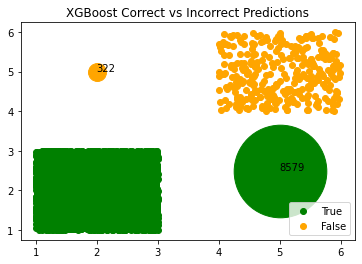

In [78]:
from matplotlib.colors import ListedColormap
import random as rnd

print(len(X_test))
true_start = 1.1
false_start = 2.1
true_tup = []
false_tup = []
for idx in range(len(X_test)):
  if classifier.predict(X_test[idx].reshape(1, -1)) == y_test[idx]:
    true_start = true_start + 0.2
    true_tup.append((rnd.uniform(1, 3), rnd.uniform(1, 3)))
  else:
    false_start = false_start + 0.2
    false_tup.append((rnd.uniform(4, 6), rnd.uniform(4, 6)))
# print(true_tup)
# print(false_tup)
plt.scatter(*zip(*true_tup), color='green')
plt.scatter(*zip(*false_tup), color='orange')
plt.scatter(2, 5, len(false_tup), color='orange')
plt.text(2, 5, len(false_tup))
plt.scatter(5, 2.5, len(true_tup), color='green')
plt.text(5, 2.5, len(true_tup))
plt.legend(["True", "False"], loc ="lower right")
plt.title("XGBoost Correct vs Incorrect Predictions")
plt.show()

# Applying PCA
Let's reduce the dimensionality to figure out the optimal number of features which can improve the performance.

In [75]:
X_train

array([[0.68888889, 0.60504202, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.28888889, 0.91596639, 0.35      , ..., 1.        , 0.        ,
        0.        ],
       [0.88888889, 0.63865546, 0.35      , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.58888889, 0.64705882, 0.5       , ..., 0.        , 1.        ,
        0.        ],
       [0.75555556, 0.5210084 , 0.25      , ..., 1.        , 0.        ,
        0.        ],
       [0.45555556, 0.77310924, 0.25      , ..., 0.        , 1.        ,
        0.        ]])

In [97]:
from sklearn.decomposition import PCA
pca = PCA(n_components=18)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [80]:
X_train_pca, X_test_pca

(array([[ 1.13690342, -0.41956778,  0.10783748, -0.45067564],
        [ 0.49468185,  0.68514108,  0.21978142,  1.17339377],
        [ 0.46501728,  0.86024153, -0.70669867,  0.30493089],
        ...,
        [-1.01097593, -0.61995464, -0.65737537, -0.1569667 ],
        [-0.53688613,  0.89635284,  0.64357756, -0.71958009],
        [-0.44052199, -0.61091517, -0.67483141, -0.67939433]]),
 array([[-0.78227015, -0.55596644,  0.7395077 , -0.34295644],
        [ 0.53203452, -0.47755152,  0.75050332, -0.04056026],
        [-0.45141281, -0.64500344, -0.67272542, -0.63590813],
        ...,
        [ 0.65623723,  0.13207967, -0.67566044,  0.25265907],
        [-0.44623785, -0.54274506,  0.71521271, -0.85095177],
        [ 1.13760852, -0.51481615, -0.68306318, -0.63310126]]))

Trying XGboost with reduced features

In [98]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[1417  996]
 [ 326 6162]]
Accuracy: 0.8514773620941467
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.59      0.68      2413
           1       0.86      0.95      0.90      6488

    accuracy                           0.85      8901
   macro avg       0.84      0.77      0.79      8901
weighted avg       0.85      0.85      0.84      8901



### **Observations**
Applying PCA on this datasets did not improve the accuracy.

Hence, going ahead with XGBoost as the chosen model (best fit) without PCA.

**XGBoost** Accuracy score = ~**96%**

In [99]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[2272  141]
 [ 181 6307]]
Accuracy: 0.9638242894056848
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2413
           1       0.98      0.97      0.98      6488

    accuracy                           0.96      8901
   macro avg       0.95      0.96      0.95      8901
weighted avg       0.96      0.96      0.96      8901



### **Save Model**
There are other file formats like json, txt, but pkl works best is what I've observed.

In [109]:
import pickle
model_name = "xgboost_classifier_model.pkl"
pickle.dump(classifier, open(model_name, "wb"))

### **Load from saved Model**

In [110]:
model = pickle.load(open(model_name, "rb"))

Predict and validate the results of the loaded model is same as the unsaved one.

In [111]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Confusion Matrix:
[[2272  141]
 [ 181 6307]]
Accuracy: 0.9638242894056848
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2413
           1       0.98      0.97      0.98      6488

    accuracy                           0.96      8901
   macro avg       0.95      0.96      0.95      8901
weighted avg       0.96      0.96      0.96      8901



## **For Data Validation**

**Transformation Function** to transform the new data

In [117]:
def transform_data(profile, transcript, portfolio):
    cust_trans = pd.merge(profile, transcript, how='inner', left_on=['id'], right_on=['person']).rename(columns={'id': 'person_id'})
    offer_val = pd.json_normalize(cust_trans['value'])
    offer_val['off_id'] = offer_val['offer id'].combine_first(offer_val['offer_id'])

    combo_df = pd.concat([cust_trans, offer_val], axis=1)
    event_combo = pd.merge(combo_df, portfolio, how='inner', left_on=['off_id'], right_on=['id']).rename(columns={'reward_y': 'reward'})
    event_combo = event_combo[['age', 'became_member_on', 'gender',
                               'person_id', 'income', 'event', 'time', 'off_id', 'channels', 
                               'difficulty', 'duration', 'offer_type', 'reward']]
    event_combo.loc[(event_combo['age'] < 20), 'age_group'] = 'UNDER_20'
    event_combo.loc[(event_combo['age'] >= 20) & (event_combo['age'] <= 40), 'age_group'] = '20_40'
    event_combo.loc[(event_combo['age'] > 40) & (event_combo['age'] <= 60), 'age_group'] = '41_60'
    event_combo.loc[(event_combo['age'] > 60) & (event_combo['age'] <= 80), 'age_group'] = '61_80'
    event_combo.loc[(event_combo['age'] > 80), 'age_group'] = 'ABOVE_80'

    current_year_month = int(datetime.today().strftime("%Y%m"))
    event_combo['membership_age'] = current_year_month - event_combo['became_member_on'].apply(lambda x: int(str(x)[:6]))

    df_completed = event_combo[event_combo['event']=='offer completed']
    df_interim = event_combo[~event_combo['person_id'].isin(df_completed['person_id'].values)]
    df_received = df_interim[df_interim['event'] == 'offer received']
    df = df_completed.append(df_received)

    df = df.join(df.channels.str.join('|').str.get_dummies())
    if 'web' not in df:
      df['web'] = 0
    if 'email' not in df:
      df['email'] = 0
    if 'mobile' not in df:
      df['mobile'] = 0
    if 'social' not in df:
      df['social'] = 0
      
    df = df.join(df.offer_type.str.get_dummies())
    if 'bogo' not in df:
      df['bogo'] = 0
    if 'discount' not in df:
      df['discount'] = 0
    if 'informational' not in df:
      df['informational'] = 0

    df = df.join(df.age_group.str.get_dummies())
    if 'UNDER_20' not in df:
      df['UNDER_20'] = 0
    if '20_40' not in df:
      df['20_40'] = 0
    if '41_60' not in df:
      df['41_60'] = 0
    if '61_80' not in df:
      df['61_80'] = 0
    if 'ABOVE_80' not in df:
      df['ABOVE_80'] = 0
      
    df = df.join(df.gender.str.get_dummies())
    if 'M' not in df:
      df['M'] = 0
    if 'F' not in df:
      df['F'] = 0
    if 'O' not in df:
      df['O'] = 0
      
    df['event_enc'] = df['event'].map({'offer received':0, 'offer completed':1})

    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    def scale_data(X, y):
      scaler = MinMaxScaler()
      X_enc = scaler.fit_transform(X)
      y_enc = y.values
      return X_enc, y_enc
    X = df.drop(columns=['age', 'became_member_on',	'gender',	'person_id',	'event',	'off_id',	
                         'offer_type', 'channels', 'age_group', 'event_enc'], axis=1)
    print(X.columns)
    y = df['event_enc']
    X, y = scale_data(X, y)
    print(f"X:\n{X}\ny:\n{y}")
    return X, y


**Some mocked up data for validation**

In [114]:
prof = [{"gender": "M", "age": 32, "id": "0b486422d4921ae7d2", 
                            "became_member_on": "20210627", "income": 20982322},
                            {"gender": "F", "age": 31, "id": "0b4864225645ae7d2", 
                            "became_member_on": "20210627", "income": 342324}]
new_profile = pd.DataFrame(prof)
trans = [{"person": "0b486422d4921ae7d2", "event": "offer received", "time": 0,
                                "value": {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}}, 
         {"person": "0b486422d4921ae7d2", "event": "offer viewed", "time": 10,
                                "value": {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}},
         {"person": "0b486422d4921ae7d2", "event": "offer received", "time": 200,
                                "value": {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}},
         {"person": "0b4864225645ae7d2", "event": "offer received", "time": 0,
                                "value": {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}},
         {"person": "0b4864225645ae7d2", "event": "offer completed", "time": 23,
                                "value": {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}}]
new_transaction = pd.DataFrame.from_dict(trans)

**Transformation**

In [118]:
X_new, y_new = transform_data(profile=new_profile, transcript=new_transaction, portfolio=portfolio)

Index(['income', 'time', 'difficulty', 'duration', 'reward', 'membership_age',
       'email', 'mobile', 'web', 'social', 'bogo', 'discount', 'informational',
       '20_40', 'UNDER_20', '41_60', '61_80', 'ABOVE_80', 'F', 'M', 'O'],
      dtype='object')
X:
[[0.    0.115 0.    0.    0.    0.    0.    1.    0.    0.    1.    0.
  0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    1.    0.    0.    1.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [1.    1.    1.    1.    0.    0.    0.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    0.    0.    0.    1.    0.   ]]
y:
[1 0 0]


**Prediction on the new data**

In [119]:
y_pred_new = model.predict(X_new)
y_pred_new

array([0, 0, 1])

**Check the accuracy on new data**

In [120]:
cm = confusion_matrix(y_new, y_pred_new)
print(f"Confusion Matrix:\n{cm}")
accuracy = accuracy_score(y_new, y_pred_new)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report(y_new, y_pred_new)}")

Confusion Matrix:
[[1 1]
 [1 0]]
Accuracy: 0.3333333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3



## Conclusion

Although the trained model gave `~96%` accuracy on the test data, it's accuracy was very poor (`~33%`) when new data was fed in for prediction on the same trained model.
